# CharRNN

If we want to model the conditionals

$$p(x_1, x_2,..., x_D) = \prod_{i} p(x_i|\mathbf{x}_{<i})$$

jointly, the model must be capable of handling variable-length inputs. A recurrent neural network (RNNs) is a natural choice for this task. Given the previous variables $x_1, \ldots, x_{i-1}$, the RNN estimates the probability distribution of the next token $p(x_i \mid x_{i-1}, x_{i-2}, \ldots, x_1)$ (Figure 1). 

<div style="display: flex; justify-content: center;">
 <img src="RNN.png" style="max-width: 50%; height: auto;">  
</div>

![RNN](RNN.png)

 <img src="RNN.png" style="max-width: 50%; height: auto;">  

<p style="text-align: center; font-size: 14px;"> 
    <strong> Figure 1 </strong>: RNN based autoregressive model. 
</p>

The CharRNN, proposed by Andrej Karpathy in 2015, is an example of an RNN-based model designed for this purpose. It was originally trained on a large corpus of text to generate new sentences. In this section, we instead use CharRNN to model binarized MNIST data. To do so, we flatten the MNIST data into a sequence and one-hot encode the digits.  

## CharRNN Implementation

For our implementation of CharRNN, we follow a similar architecture to that described in the original blog. We use a 2-layer LSTM with 128 hidden dimensions and a dropout rate of $0.2$. The output of the LSTM is then fed into a 2-layer feedforward network with ReLU activation and 128 hidden units. The model outputs 2 real numbers, representing the logits for classes $0$ and $1$.

<div style="display: flex; justify-content: center;">
 <img src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/CharRNN.png" style="max-width: 50%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px;"> 
    <strong> Figure 2 </strong>: CharRNN architecture
</p>

In [14]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from CharRNN import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

class MNISTDataset(Dataset):
    """
    Custom MNIST dataset: binarizes each image and one hot encodes the label
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.__len__()

    def __getitem__(self, idx):
        X, _ = self.data.__getitem__(idx)
        X = torch.where(X > 0, torch.tensor(1), torch.tensor(0))
        return F.one_hot(X[:-1], num_classes=2), X[1:]
    
dataset = MNISTDataset(train_dataset)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [7]:
class CharRNN(nn.Module):
    """
    Implementation of CharRNN for Binary MNIST data
    """
    def __init__(self, vocab_size, hidden_dim):
        """
        @param vocab_size (V): int
        @param embedding_dim (E): int
        @param hidden_dim (H): int
        @param length (L): int
        @param batch_size (B): int
        """
        super(CharRNN, self).__init__()
        self.rnn = nn.LSTM(vocab_size, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(in_features=hidden_dim, out_features=vocab_size))

    def forward(self, x):
        """
        @param x: torch.tensor [B, L, 2]

        Shape after RNN: [B, L, H]
        Shape after out: [B, L, V]
        """
        x, _ = self.rnn(x)
        out = self.linear(x)
        return out

    def generate(self, n_samples, max_len=28**2, vocab_size=2, device="cpu"):
        """
        @param n_samples: int
            Number of samples to geneerate
        @param max_len: int
            Length of the generated sample
        @param vocab_size: int
        @param device: string
        """
        self.eval()
        samples = torch.zeros((n_samples, max_len), dtype=torch.long).to(DEVICE)
        for i in range(1, max_len):
            x = samples[:, :i]
            x = F.one_hot(x, num_classes=vocab_size).float().to(DEVICE)
            logits = self.forward(x)
            logits = logits[:, -1, :]
            prob = F.softmax(logits, dim=1)
            epsilon = torch.rand(n_samples, 1).to(DEVICE)
            characters = (epsilon >= prob[:, :1]).long()
            samples[:, i] = characters.squeeze(1)
        samples = samples.view(n_samples, int(max_len**0.5), int(max_len**0.5))
        samples = samples.detach().cpu().numpy()
        return samples

We train the model for approximately 200 epochs using the Adam optimizer with a learning rate of $10^{-6}$. During experimentation, we observed that if the learning rate is set too high (around $10^{-3}$), the model fails to train properly. Therefore, it is necessary to use a much lower learning rate.

In [14]:
charrnn = CharRNN(vocab_size=2, hidden_dim=128)
train(charrnn, dataloader, 20, device=DEVICE, lr=1e-6)

## Sample generation

After training, we see that the model can generate handwritten digits overall. However, at times, the strokes become discontinuous at the boundaries. This issue arises because CharRNN flattens the images, which results in the boundary points of the MNIST images being directly connected. Therefore, the model sometimes fails to recognize the image boundaries and continues the stroke beyond them.

<div style="display: flex; justify-content: center;">
 <img                src="/Users/raymondtsao/Desktop/UnsupervisedLearningNotes/notes/Autoregressive/figures/charrnn_order.png"  style="max-width: 25%; height: auto;">  
</div>

<p style="text-align: center; font-size: 14px;"> 
    <strong> Figure 2 </strong>: Raster ordering: When flattened, the model treats pixel 5 as directly connected to pixel 4, which can cause discontinuities in the stroke.
</p>

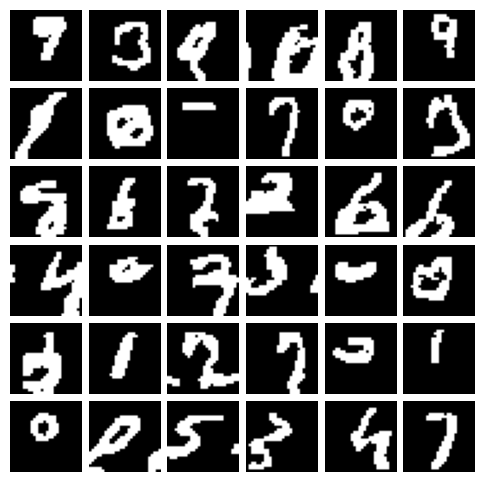

In [14]:
n_samples = 36
samples = charrnn.generate(n_samples)
plot_samples(samples)

If we shift such image by a few pixels, we see that we can recover the good digits. This suggests that we might need to inject positional information in the model. 

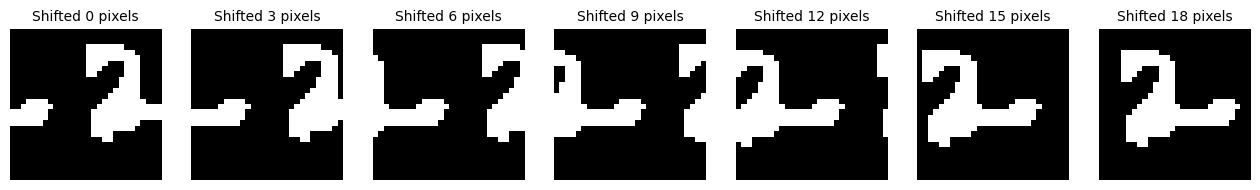

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(16, 3))
shift = [0, 3, 6, 9, 12, 15, 18]
for i in range(7):
    ax[i].imshow(shiftImage(samples[3], shift[i]), cmap='gray')
    ax[i].set_title(f"Shifted {shift[i]} pixels", fontsize=10)
    ax[i].axis('off')
plt.show()

## CharRNN with positional encoding

We now apply position encoding to the one-hot encoded images. Instead of using sinusoidal position encoding as in transformers, we concatenate the $(x, y)$ coordinates with the one-hot encoded vector. In other words, the input consists of a vector of the form $[x, y, e_0, e_1]$, where $e_0$ and $e_1$ are indicator variables.

In [ ]:
charrnn_with_pos = CharRNN(2, 128)
train_with_pos(charrnn_with_pos, dataloader, 20, device=DEVICE, lr=1e-6)

## Sample generation with positional encoding

After injecting positional information, the discontinuities disappear, and the digits are now centered within each frame.

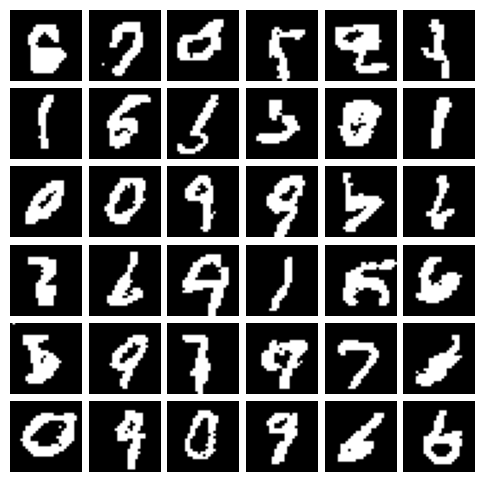

In [ ]:
num_samples = 36
samples = sample_with_position(charrnn_with_pos, num_samples, device=DEVICE)
plot_samples(samples)

## Citation

[1] http://karpathy.github.io/2015/05/21/rnn-effectiveness/